# Feature Analysis

In [1]:
import pandas as pd
import math

In [2]:
#filenames1 = ['pionminus_new0','pionminus_new1','pionminus_new2','pionminus_new3','pionminus_new4','pionminus_new5']
filenames1 = ['pionminus_100M_v0','pionminus_100M_v1','pionminus_100M_v2','pionminus_100M_v3']
filenames2 = ['eccbar','electron_50M_v0']#'electron1'
filepath = "/home/yoren/bnl/PHENIX/ee/ML/"

hadron_weight = 25000*50/500
hadron_weight = 500

In [3]:
if True:
    data1 = pd.read_csv(filepath+f'{filenames1[0]}.csv')
    data1['phi0'] = 0
    for ifile in range(1,len(filenames1)):
        idata = pd.read_csv(filepath+f'{filenames1[ifile]}.csv')
        idata['phi0'] = 0
        print(idata.shape[0])
        #idata = idata[:int(idata.shape[0]/6)]
        #print(idata.shape[0])
        data1 = pd.concat([data1,idata], sort=False)

    data2 = pd.read_csv(filepath+f'{filenames2[0]}.csv')
    data2['phi0'] = 1
    for ifile in range(1,len(filenames2)):
        idata = pd.read_csv(filepath+f'{filenames2[ifile]}.csv')
        idata['phi0'] = 1
        data2 = pd.concat([data2,idata], sort=False)

    data = pd.concat([data1,data2], sort=False)
    data = data[(data['pt'] > 0.4) & (data['pt'] < 25) & (data['n0'] > -1)  ]

    data = data.sample(frac = 1)
    

    data.head()

1068984
1069245
1005314


In [4]:
if True:
    data['disp2'] = data['n0']-data['disp']*data['disp']/8.
    data['centr+pt'] = data['centrality']/20.+data['pt']*data['pt']
    data['n0*pt'] = data['n0']+4*data['pt']
    data['e/p*pt'] = 1./((data['e/p']-0.9)*(data['e/p']-0.9)+0.25)/(1.25-data['prob'])+4*data['pt']
if False:
    data['disp2'] = data.apply(lambda row: row['n0']-row['disp']**2, axis=1)
    data['chi2/npe0'] = data.apply(lambda row: row['chi2']/(row['npe0']+0.001), axis=1)
    #data['e/p*prob'] = data.apply(lambda row:  1./(abs(row['e/p']-0.9)+0.25)/(1.25-row['prob']), axis=1)
    #data['n0*prob'] = data.apply(lambda row: (row['n0']-2)/(1.00001-row['prob']), axis=1)
    data['centr+pt'] = data.apply(lambda row: row['centrality']/20.+row['pt']*2, axis=1)
    data['e/p*pt'] = data.apply(lambda row: row['n0']+4*row['pt'], axis=1)
    data['n0*pt'] = data.apply(lambda row: 1./(abs(row['e/p']-0.9)+0.25)/(1.25-row['prob'])+4*row['pt'], axis=1)

In [5]:
if False:
    fliname_loc = 'TreenewDB'
    data = pd.read_csv(filepath+f'{fliname_loc}.csv')

In [6]:
data.head()

centrality       zdc        pt       e/p  n0      disp  chi2/npe0  \
8889970          36 -52.28125  0.474559  0.914498   5  1.501507   1.315547   
7961029          60 -45.28125  0.790571  1.007606   3  5.566625   3.677136   
8099629          29 -21.75000  0.481106  0.660405   6  2.801024   7.171771   
129234            9 -39.53125  0.581786  1.006951   4  2.043846  14.656114   
7497128          17  76.00000  1.722066  1.099494   5  2.100212   1.707722   

         npe0      prob   emcdphi     emcdz  phi0      disp2  centr+pt  \
8889970    11  0.984916  0.004021  0.664154     1   2.745476  2.749118   
7961029     4  0.095570  0.001487  2.249001     1 -27.987315  4.581141   
8099629    12  0.004727 -0.007782  2.796341     1  -1.845737  2.412213   
129234      6  0.000855 -0.001653 -1.466476     0  -0.177305  1.613572   
7497128    16  0.707635 -0.004741 -0.376373     1   0.589109  4.294131   

             n0*pt     e/p*pt  
8889970   6.898235  16.975105  
7961029   6.162282   6.473819  
8099629   7.924425   4.536727  
129234    6.327143   5.389229  
7497128  11.888262  13.250551

In [7]:
print(data.size, data.shape)

290474832 (18154677, 16)


In [8]:
# удалим лишние колонки
data = data.drop(columns = ['zdc','emcdphi','emcdz'])

In [9]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(3, 3, figsize=(15, 6))
    for i, feature in enumerate(['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2/npe0', 'npe0', 'prob', 'phi0']):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)


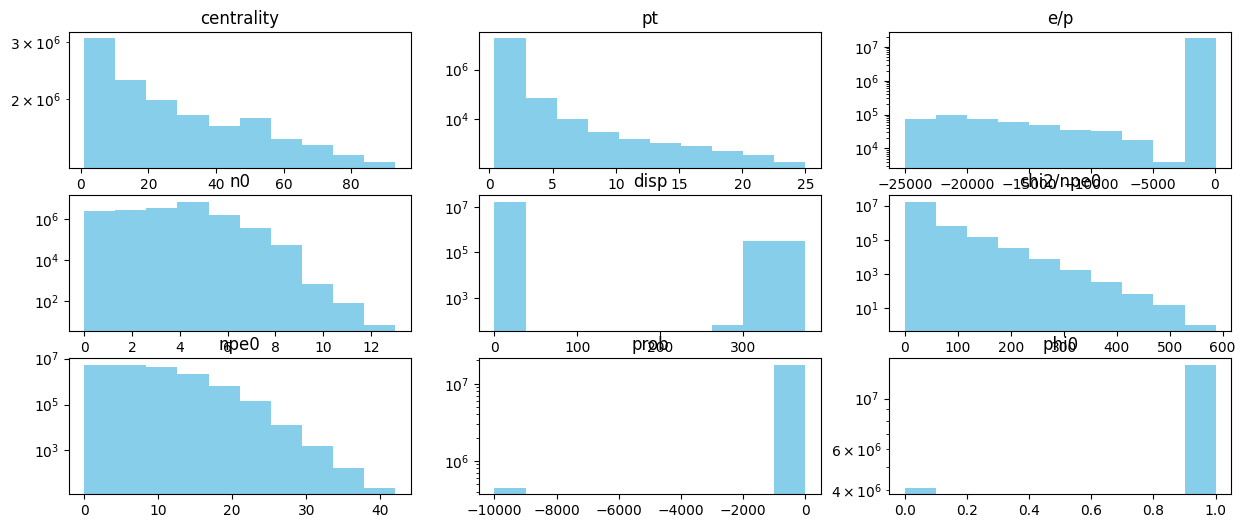

In [10]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [11]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # делим выборку на train и test
    #data = data.sort_values(by='date_time', ignore_index=True)
    #cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    #cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)
    kek_data = data[cut_off_test:]
    y = data['phi0']
    data = data.drop(columns = ['phi0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    #enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    #enc.fit(data_train)
    #transformed_train = enc.transform(data_train)
    #transformed_test = enc.transform(data_test)
    
    return data_train, data_test, y_train, y_test,cut_off_val, kek_data

In [12]:
X_train_all, X_test, y_train_all, y_test, cut_off_val, kek_data = feature_engineering(data)

6051559 12103119


In [13]:
X_test

centrality        pt       e/p  n0        disp  chi2/npe0  npe0  \
5986438          19  0.534093  0.929137   2    6.249042  11.274362     3   
4872483          73  0.587884  0.860622   4    3.660896   2.235999    10   
5401906          26  0.603983  0.901761   3    2.727068   9.657304     9   
1009264          24  0.451561  0.488342   1    6.908938  37.354553     0   
9354994          71  0.417877  1.246246   2    2.327567   7.098297     7   
...             ...       ...       ...  ..         ...        ...   ...   
7405156          36  0.704368  0.967195   0  311.807281  85.443298     0   
4642272          39  0.750325  0.993096   5    3.324495   1.598129    10   
6700476          86  1.189049  0.932889   5    2.454181   0.130540     7   
2681815          41  0.829998  1.131026   4    3.850729  17.767998     9   
1296892          75  0.508897  0.897505   4    2.259436   2.371336     8   

             prob         disp2  centr+pt     n0*pt     e/p*pt  
5986438  0.996000    -37.050520  2.018186  4.136372  17.831125  
4872483  0.922244     -9.402156  4.825769  6.351538  14.480508  
5401906  0.081857     -4.436898  2.507965  5.415931   5.840128  
1009264  0.000147    -46.733423  2.103123  2.806246   3.713674  
9354994  0.978103     -3.417570  4.385755  3.671510  11.614745  
...           ...           ...       ...       ...        ...  
7405156  0.002634 -97223.780793  3.208736  2.817472   5.967341  
4642272  0.341700     -6.052269  3.450650  8.001300   7.257579  
6700476  0.735990     -1.023007  6.678098  9.756196  12.504626  
2681815  0.928418    -10.828114  3.709997  7.319994  13.570154  
1296892  0.884044     -1.105052  4.767793  6.035587  12.965585  

[6051558 rows x 12 columns]

In [14]:
X_train, X_val = X_train_all, X_train_all[cut_off_val:]
y_train, y_val = y_train_all, y_train_all[cut_off_val:]
w_train, w_val = y_train-1, y_val-1
w_test = y_test-1
w_train_all = y_train_all - 1
w_train = w_train*(-hadron_weight)+1
w_val = w_val*(-hadron_weight)+1
w_test = w_test*(-hadron_weight)+1
w_train_all = w_train_all*(-hadron_weight)+1

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [15]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=2, learning_rate= 0.1, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(X_train, y_train, w_train)

predicted = gb_clf.predict(X_test)

# calculating the main quality metrics
print(metrics.classification_report(y_test, predicted))

print('confusion matrix')
print(metrics.confusion_matrix(y_test, predicted))

/home/yoren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/yoren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/yoren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.22      1.00      0.37   1354017
           1       0.00      0.00      0.00   4697541

    accuracy                           0.22   6051558
   macro avg       0.11      0.50      0.18   6051558
weighted avg       0.05      0.22      0.08   6051558

confusion matrix
[[1354017       0]
 [4697541       0]]


In [16]:
# search for parameters
# https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv
import time
from sklearn.model_selection import GridSearchCV

start = time.time() 

parameters = {
    "loss":["log_loss"],
    "learning_rate": [0.4],
    "min_samples_split": [0.0001],
    "max_depth":[10],
    "max_features":["sqrt"],
    "criterion": ['squared_error'],
    "n_estimators":[10]
    }

classif = GradientBoostingClassifier()
classif.set_params(init='zero')

clf = GridSearchCV(classif, parameters, cv=3, n_jobs=3)

clf.fit(X_train, y_train, sample_weight=w_train)
print('точность: ', clf.score(X_test, y_test))

# getting the best parameters ans score
print(clf.best_params_)
print(clf.best_score_)

stop = time.time()    
print('time of execution (sec)', stop - start)

точность:  0.639178208322551
{'criterion': 'squared_error', 'learning_rate': 0.4, 'loss': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 0.0001, 'n_estimators': 10}
0.6442206343670586
time of execution (sec) 1030.7201483249664


# Cross Validation

In [17]:
predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.38      1.00      0.55   1354017
           1       1.00      0.54      0.70   4697541

    accuracy                           0.64   6051558
   macro avg       0.69      0.77      0.63   6051558
weighted avg       0.86      0.64      0.67   6051558



In [18]:
y_pred_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Model Evaluation

log loss: 0.02276349568755496
roc auc: 0.9774722608260695
f1 score: 0.9502477279680583


Text(0.5, 1.0, 'ROC AUC Curve')

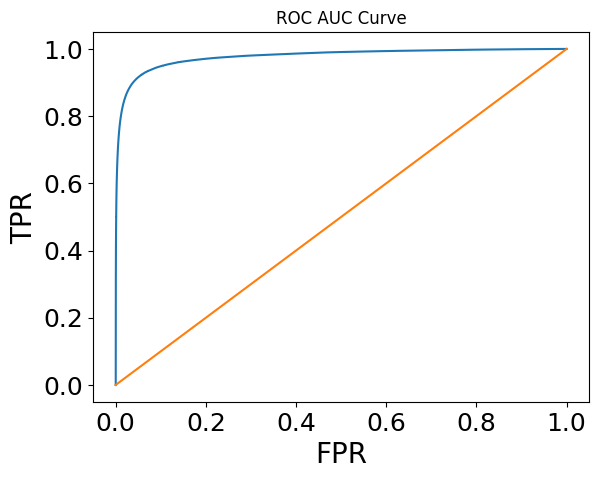

In [19]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs, sample_weight=w_test))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1, sample_weight=w_test)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.xticks(fontsize = 18) 
plt.yticks(fontsize = 18) 
plt.title('ROC AUC Curve')

In [20]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.5316094745626042


In [21]:
i = 550000
print(round(tpr[i],3),round(fpr[i]/tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
#print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.589 0.0034
0.35979172067152143 0.0020332093319360097 0.589462444287341


In [22]:
print(sum(predicted),len(predicted))

2517753 6051558


In [23]:
#kek_data = data
#kek_data = kek_data.drop(columns = ['phi0'])
proba_loc = clf.predict_proba(X_test)
print(proba_loc[0][1])

0.01550684817918758


In [24]:
import ROOT as root
outfile = root.TFile.Open("output/BDT_test1.root", "recreate")
e_pt_hist_AI = root.TH2D("e_pt_hist_AI", "e_pt_hist_AI", 40, 0, 10, 10, 0, 100)
h_pt_hist_AI = root.TH2D("h_pt_hist_AI", "h_pt_hist_AI", 40, 0, 10, 10, 0, 100)
e_pt_hist_SC = root.TH2D("e_pt_hist_SC", "e_pt_hist_SC", 40, 0, 10, 10, 0, 100)
h_pt_hist_SC = root.TH2D("h_pt_hist_SC", "h_pt_hist_SC", 40, 0, 10, 10, 0, 100)
e_pt_hist_NC = root.TH2D("e_pt_hist_NC", "e_pt_hist_NC", 40, 0, 10, 10, 0, 100)
h_pt_hist_NC = root.TH2D("h_pt_hist_NC", "h_pt_hist_NC", 40, 0, 10, 10, 0, 100)

Welcome to JupyROOT 6.30/06


In [25]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = kek_data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>10000000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2/npe0'], row['npe0'], row['prob'], row['phi0']
    if pt<0.4 or centrality<0: continue
    if phi0: e_pt_hist_NC.Fill(pt,centrality)
    else:    h_pt_hist_NC.Fill(pt,centrality)
    if ep>0.8 and n0>=2 and disp <5 and prob>0.01 and chi2<10: 
        if phi0: 
            mycute+=1
            e_pt_hist_SC.Fill(pt,centrality)
        else: 
            mycuth+=1+hadron_weight
            h_pt_hist_SC.Fill(pt,centrality)
    if proba_loc[counter][1]>thresholds[i]: 
        #if ep<=0.5: print(ep)
        if phi0: 
            AIcute+=1
            e_pt_hist_AI.Fill(pt,centrality)
        else: 
            AIcuth+=1+hadron_weight
            h_pt_hist_AI.Fill(pt,centrality)
    if phi0: norm_e+=1
    else: norm_h+=1+hadron_weight
    #if counter<10: 
    #    print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

In [26]:
print(norm_e, norm_h,round(mycute/norm_e,3),round(mycuth/norm_h,3), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i]/tpr[i],3))

4697541 678362517 0.58 0.011 0.589 0.002 0.003 0.003


In [27]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h))

5.447 1.016 0.187 8698


In [28]:
%run input/Format.ipynb
%jsroot on

/home/yoren/.local/lib/python3.10/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


In [29]:
c1 = root.TCanvas("c1","c1",1400,2500)
c1.Divide(2,5)
part_names_legend= [ "prompt e^{-} " , "#gamma#rightarrow e^{-} "]
centralities_legend = ["0-20%","20-40%","40-60%","60-80%","80-93%"]
legends = []
for icentr in range(5):

    c1.cd(1+2*icentr)
    root.gPad.SetLogy()
    e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}").SetLineWidth(312)
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}").SetLineWidth(3)
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}").SetLineWidth(3)
    e_pt_hist_NC.SetLineColor(4)
    e_pt_hist_SC.SetLineColor(2)
    e_pt_hist_AI.SetLineColor(1)
    proj = e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}",2*icentr+1,2*icentr+2)
    proj.SetMinimum(2)
    Format_Hist_total(proj, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    proj.Draw()
    phoj_s = e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2)
    phoj_s.Draw("same")
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same")

    legends.append(Draw_Legend_Title(0.65,0.65,0.95,0.95,part_names_legend[0]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].AddEntry(phoj_s,"std","l")
    legends[-1].AddEntry(e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2),"bdt","l")
    legends[-1].Draw()

    c1.cd(2+2*icentr)
    root.gPad.SetLogy()
    h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}").SetLineWidth(3)
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}").SetLineWidth(3)
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}").SetLineWidth(3)
    h_pt_hist_NC.SetLineColor(4)
    h_pt_hist_SC.SetLineColor(2)
    h_pt_hist_AI.SetLineColor(1)
    projh = h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}",2*icentr+1,2*icentr+2)
    Format_Hist_total(projh, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    projh.SetMinimum(2)
    projh.Draw()
    phoj_sd = h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2)
    phoj_sd.Draw("same")
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same")

    legends.append(Draw_Legend_Title(0.7,0.65,0.95,0.95,part_names_legend[1]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].AddEntry(phoj_sd,"std","l")
    legends[-1].AddEntry(h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2),"bdt","l")
    legends[-1].Draw()
c1.Draw()
print(h_pt_hist_NC.GetBinContent(10,1),e_pt_hist_NC.GetBinContent(10,1))

2226.0 2154.0


In [30]:
if False:
    e_pt_hist_AI.Write()
    h_pt_hist_AI.Write()
    e_pt_hist_SC.Write()
    h_pt_hist_SC.Write()
    e_pt_hist_NC.Write()
    h_pt_hist_NC.Write()
    outfile.Close()

In [31]:
import pickle
with open('output/bdt.pkl','wb') as f:
    pickle.dump(clf,f)

#print(clf.predict(X_test[0:10]))

In [32]:
import pickle
# load
with open('output/bdt.pkl', 'rb') as f:
    clf2 = pickle.load(f)
print(clf2.predict(X_test[0:10]))

[0 1 0 0 1 0 0 0 0 1]


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.222175 to fit



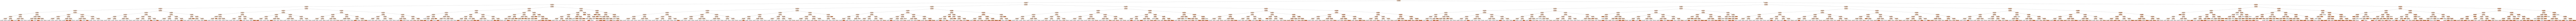

In [33]:
sub_tree_42 = clf2.best_estimator_[0, 0]
from sklearn.tree import export_graphviz, export_text
from sklearn.tree import _tree
# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)

graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path('output/out.png').write_bytes(png)
# Display
Image(png)

In [34]:
clf2.predict(X_test[0:100])

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1])

In [35]:
clf2.predict_proba(X_test[0:100])

array([[0.98449315, 0.01550685],
       [0.06900661, 0.93099339],
       [0.91573761, 0.08426239],
       [0.99195082, 0.00804918],
       [0.48463244, 0.51536756],
       [0.98141229, 0.01858771],
       [0.99179023, 0.00820977],
       [0.95626346, 0.04373654],
       [0.76309565, 0.23690435],
       [0.12144238, 0.87855762],
       [0.36815646, 0.63184354],
       [0.75028688, 0.24971312],
       [0.99201744, 0.00798256],
       [0.99025367, 0.00974633],
       [0.90421165, 0.09578835],
       [0.09780501, 0.90219499],
       [0.01907687, 0.98092313],
       [0.55275848, 0.44724152],
       [0.46652248, 0.53347752],
       [0.99192185, 0.00807815],
       [0.08679733, 0.91320267],
       [0.99018598, 0.00981402],
       [0.87071516, 0.12928484],
       [0.99184737, 0.00815263],
       [0.85106128, 0.14893872],
       [0.83582858, 0.16417142],
       [0.56639871, 0.43360129],
       [0.85721131, 0.14278869],
       [0.06844924, 0.93155076],
       [0.44305966, 0.55694034],
       [0.

In [36]:
print( clf2.best_params_)

{'criterion': 'squared_error', 'learning_rate': 0.4, 'loss': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 0.0001, 'n_estimators': 10}


In [37]:
clf2.best_estimator_.predict_proba(X_test[9:20])

array([[0.12144238, 0.87855762],
       [0.36815646, 0.63184354],
       [0.75028688, 0.24971312],
       [0.99201744, 0.00798256],
       [0.99025367, 0.00974633],
       [0.90421165, 0.09578835],
       [0.09780501, 0.90219499],
       [0.01907687, 0.98092313],
       [0.55275848, 0.44724152],
       [0.46652248, 0.53347752],
       [0.99192185, 0.00807815]])

In [38]:
y = clf2.best_estimator_[0, 0].predict(X_test[9:19].values.tolist())*0
#y = gb_clf.decision_function(X_test[9:20])

rate = clf2.best_params_['learning_rate']
print(rate)
for i in range(0,10):
    sub_tree = clf2.best_estimator_[i, 0]
    y += rate*sub_tree.predict(X_test[9:19].values.tolist())
print(y)
print(gb_clf.decision_function(X_test[9:20]))
z=y
for i in range(len(z)): 
    z[i] = 1./(1+np.exp(-z[i]))
print(z)

0.4
[ 1.97884154  0.5401338  -1.1001429  -4.82248209 -4.62107056 -2.24492237
  2.22185486  3.94001767 -0.21182239  0.13411074]
[-4.27894478 -4.78132315 -4.05085266 -5.12047971 -4.78132315 -4.78132315
 -4.04090039 -1.03712272 -4.78132315 -4.78132315 -5.12047971]
[0.87855762 0.63184354 0.24971312 0.00798256 0.00974633 0.09578835
 0.90219499 0.98092313 0.44724152 0.53347752]


In [39]:
best_gbc = clf2.best_estimator_

In [40]:
n_estim = best_gbc.n_estimators

In [41]:
learning_rate = best_gbc.learning_rate
print(clf2.decision_function(X_test[9:19]))
arr = clf2.decision_function(X_test[9:19])
print(1./(1.+np.exp(-arr)))
#tree_scores = [best_gbc.estimators_[i, 0].decision_function(X_test[9:19].values.tolist()) for i in range(10)]
print(learning_rate)

[ 1.97884154  0.5401338  -1.1001429  -4.82248209 -4.62107056 -2.24492237
  2.22185486  3.94001767 -0.21182239  0.13411074]
[0.87855762 0.63184354 0.24971312 0.00798256 0.00974633 0.09578835
 0.90219499 0.98092313 0.44724152 0.53347752]
0.4


In [42]:
log_odds_predictions = []
for tree in clf2.best_estimator_:
    # For each tree, get the predicted values for each sample
    leaf_indices = tree[0].apply(X_test[9:19].values.tolist())  # Get the leaf indices for the training data
    leaf_values = tree[0].tree_.value  # Get the values at each leaf

    # Average the values for each leaf to interpret them as log odds
    predicted_log_odds = [leaf_values[leaf_indices[i]].mean() for i in range(len(X_test[9:19]))]
    log_odds_predictions.append(predicted_log_odds)

In [43]:
print(log_odds_predictions)

[[-0.695359784801614, -0.6906469990509989, -1.4949851386381836, -1.998804080680359, -1.9929079670702186, -1.830012290135782, 2.0, 1.900556598546062, -1.3959216767340983, -1.201928942857973], [1.343765849311019, 0.08486882135854516, -0.8973696323979642, -1.4470960746411496, -1.443288458534942, -1.3928650085978183, 0.8724119982790532, 1.4915209336553803, -0.8679597410460268, -0.24586445019462705], [0.7022492347350626, 0.01952895716098633, -0.5342293362880951, -1.249212059163872, -1.228417072782821, -0.9372907720380549, 0.07478741559427357, 1.027921274198779, -0.32497893223068886, -0.5835544205737585], [0.9674906704842531, 0.35200782750236925, 1.6675494190498399, -1.1511710895091054, -1.1130910558019393, -0.6107564243096769, 1.6352487115725751, 1.1224792152047842, 0.21649377166024028, 0.5558248001942883], [1.082841689678173, 0.3174006947069224, -0.781515314846415, -1.0933746666952586, -1.0856227986097227, -0.7237988143276791, 0.11907884831215246, 0.9043575477028712, 1.302835727787496, 0.4

In [44]:
rate = clf2.best_params_['learning_rate']
myarr = [log_odds_predictions[i][0] for i in range(10)]
print(rate,rate*sum(myarr))
print(clf2.decision_function(X_test[9:19]))

0.4 1.9788415411515925
[ 1.97884154  0.5401338  -1.1001429  -4.82248209 -4.62107056 -2.24492237
  2.22185486  3.94001767 -0.21182239  0.13411074]


In [45]:
print(best_gbc.estimators_.shape[0])
print(best_gbc.estimators_.shape[1])
y = []
for i in range(10):
    y0=[]
    for j in range(n_estim):
        sub_tree = clf2.best_estimator_[j, 0]
        y0.append(sub_tree.predict(X_test[9+i:10+i].values.tolist())[0])
    y.append(y0)
print(y)

10
1
[[-0.695359784801614, 1.343765849311019, 0.7022492347350626, 0.9674906704842531, 1.082841689678173, 1.0616265248859305, 0.8020295111446093, -0.6668553252159009, 0.10561665277070367, 0.24369882988674482], [-0.6906469990509989, 0.08486882135854516, 0.01952895716098633, 0.35200782750236925, 0.3174006947069224, 0.28829658173506006, 0.451918034098488, 0.1684479906885133, 0.10561665277070367, 0.25289592841417324], [-1.4949851386381836, -0.8973696323979642, -0.5342293362880951, 1.6675494190498399, -0.781515314846415, -0.557549267127124, -0.5650766003265206, 0.16725817432648968, 0.09846021212042758, 0.1471002449924878], [-1.998804080680359, -1.4470960746411496, -1.249212059163872, -1.1511710895091054, -1.0933746666952586, -1.059483247535024, -1.0346373232060955, -1.0235952042914722, -1.009773403947953, -0.9890580694647738], [-1.9929079670702186, -1.443288458534942, -1.228417072782821, -1.1130910558019393, -1.0856227986097227, -1.0056809235346156, -1.0117187936986853, -0.960020910018831, -

In [46]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if ( "
        
        for p in path[:-1]:
            if rule != "if ( ":
                rule += " && "
            rule += str(p)
        rule += " ) "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [47]:
import numpy as np
from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if  "
        
        for p in path[:-1]:
            if rule != "if  ":
                rule += " if "
            rule += str(p)
        rule += "  "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [48]:
#print(f"double mytree{list(X_test.columns)}")
print('{')
for iestim in range(n_estim):
    print(f"    if (iestim == {iestim})")
    print('    {')
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(X_test.columns), None)
    for r in rules:
        print("       ",r)
    print('    }')
print ('    return -9999;')
print('};')

{
    if (iestim == 0)
    {
        if  (x[8] <= -2.8184) if (x[2] <= 0.82046) if (x[0] <= 75.5) if (x[8] <= -11.87411) if (x[2] <= 0.75054) if (x[11] > 2.92008) if (x[1] > 0.52065) if (x[3] <= 2.5) if (x[4] > 6.03736) if (x[10] <= 101.2725)   return -1.9994302924893608;  // | based on 916,484 samples
        if  (x[8] > -2.8184) if (x[0] > 59.5) if (x[3] > 3.5) if (x[6] > 7.5) if (x[11] > 6.88293) if (x[7] > 0.03949) if (x[1] <= 5.67762) if (x[0] > 66.5) if (x[2] > 0.65196) if (x[2] > 0.75062)   return 1.900556598546062;  // | based on 707,478 samples
        if  (x[8] > -2.8184) if (x[0] <= 59.5) if (x[2] > 0.81752) if (x[9] > 2.85952) if (x[6] > 6.5) if (x[7] > 0.08548) if (x[10] > 6.8599) if (x[5] <= 6.18795) if (x[2] <= 1.17766) if (x[2] > 0.84513)   return 1.591331459946415;  // | based on 700,193 samples
        if  (x[8] <= -2.8184) if (x[2] <= 0.82046) if (x[0] <= 75.5) if (x[8] <= -11.87411) if (x[2] <= 0.75054) if (x[11] > 2.92008) if (x[1] > 0.52065) if (x[3] <= 2.5) if (x

In [49]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " : "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f"  # | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [50]:
print(f"def mytree( iestim,  x ) :")
for iestim in range(n_estim):
    print(f"    if iestim == {iestim}:")
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(X_test.columns), None)
    for r in rules:
        print("       ",r)
print ('    return -9999')

def mytree( iestim,  x ) :
    if iestim == 0:
        if (x[8] <= -2.8184) and (x[2] <= 0.82046) and (x[0] <= 75.5) and (x[8] <= -11.87411) and (x[2] <= 0.75054) and (x[11] > 2.92008) and (x[1] > 0.52065) and (x[3] <= 2.5) and (x[4] > 6.03736) and (x[10] <= 101.2725) :  return -1.9994302924893608  # | based on 916,484 samples
        if (x[8] > -2.8184) and (x[0] > 59.5) and (x[3] > 3.5) and (x[6] > 7.5) and (x[11] > 6.88293) and (x[7] > 0.03949) and (x[1] <= 5.67762) and (x[0] > 66.5) and (x[2] > 0.65196) and (x[2] > 0.75062) :  return 1.900556598546062  # | based on 707,478 samples
        if (x[8] > -2.8184) and (x[0] <= 59.5) and (x[2] > 0.81752) and (x[9] > 2.85952) and (x[6] > 6.5) and (x[7] > 0.08548) and (x[10] > 6.8599) and (x[5] <= 6.18795) and (x[2] <= 1.17766) and (x[2] > 0.84513) :  return 1.591331459946415  # | based on 700,193 samples
        if (x[8] <= -2.8184) and (x[2] <= 0.82046) and (x[0] <= 75.5) and (x[8] <= -11.87411) and (x[2] <= 0.75054) and (x[11] > 2.92008)

In [51]:
def mytree(x,y):
    return 0

In [52]:
def mygradboost (x, lerning_rate = 0.2):
    prob = 0
    for i in range (n_estim):
        prob+=lerning_rate*mytree(i, x)
    return 1. / ( 1. + np.exp( - prob ) )


In [53]:
def mybdt(x, prob):
    if mygradboost(x)>prob: return 1
    return  

In [54]:
iestim = 9
sub_tree = clf2.best_estimator_[iestim, 0]
y = sub_tree.predict(X_test[9:19].values.tolist())
print(y)

myf = [mytree(iestim, X_test[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[ 0.24369883  0.25289593  0.14710024 -0.98905807 -0.74152245  0.25764811
 -0.04732351  0.25289593  0.11908716  0.32816216]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [55]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(X_test[9:19].values.tolist())
print(y)

myf = [mygradboost(X_test[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[[0.12144238 0.87855762]
 [0.36815646 0.63184354]
 [0.75028688 0.24971312]
 [0.99201744 0.00798256]
 [0.99025367 0.00974633]
 [0.90421165 0.09578835]
 [0.09780501 0.90219499]
 [0.01907687 0.98092313]
 [0.55275848 0.44724152]
 [0.46652248 0.53347752]]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [56]:
input_x = [ X_test[9:19].values.tolist()[0][i] for i in range(len(X_test[9:19].values.tolist()[0])) ]
print(input_x)

[56.0, 0.5341727137565613, 0.7928406467285728, 7.0, 1.3891093730926514, 1.4125843542859984, 10.0, 0.9816105365753174, 5.070375149586141, 3.8683454275131224, 9.136690855026245, 16.38590351314498]


In [57]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(X_test[9:19].values.tolist())
y = [y[i][1] for i in range(len(y))]
print(y)

myf = [mygradboost(X_test[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[0.878557615541655, 0.6318435414895064, 0.24971312102089085, 0.007982555550411297, 0.009746327900913534, 0.09578835201712126, 0.9021949893653125, 0.9809231334333877, 0.44724152307577986, 0.5334775237021587]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [58]:
column_headers = list(X_test.columns.values)
print(column_headers)
print(len(column_headers))

['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2/npe0', 'npe0', 'prob', 'disp2', 'centr+pt', 'n0*pt', 'e/p*pt']
12
